<a href="https://colab.research.google.com/github/mrcreasey/oc-ds-p8-pyspark-deploy/blob/main/pyspark_sur_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pyspark sur Google Colab

Initialisation of PySpark from <https://www.pauldesalvo.com/how-to-install-spark-on-google-colab/>

Uncomment the following lines to setup your environment in colab

Lines are commented out to prevent accidental destruction of existing java/spark configuration when not in isolated  Colab environment !!

In [1]:
#!sudo apt update
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
#!wget -q https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
#!tar xf spark-3.3.0-bin-hadoop3.tgz
#!pip install -q findspark
#!pip install pyspark
#!pip install py4j


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://security.ubuntu.com/ubuntu 

In [2]:

import os
import sys
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"



In [3]:
import pyspark
import findspark
findspark.init()
findspark.find()

'/content/spark-3.3.0-bin-hadoop3'

In [4]:
from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession.builder.appName("Our First Spark Example").getOrCreate()

spark

# Copy images

Des images de fruits sont disponibles sur
- https://www.kaggle.com/datasets/moltean/fruits

Un copie de ce jeu de données ce trouve aussi à
- https://github.com/Horea94/Fruit-Images-Dataset 

On crée un jeu de données pour traitement avec PySpark


In [5]:
# delete folder
if os.path.exists('data/train'):
    %rm -rf 'data/train'

In [6]:
import io
from PIL import Image  # https://pillow.readthedocs.io/en/4.3.x/
import requests  # http://docs.python-requests.org/en/master/


# example image url: https://github.com/Horea94/Fruit-Images-Dataset/tree/master/Training/
def download_image(url, image_file_path):
    # https://gist.github.com/mjdietzx/545fa2874b2688e9bcb71e2ee92cd5a0
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    # print(f'Image downloaded from url: {url} and saved to: {image_file_path}')

if not os.path.exists('data'): os.makedirs('data')

# test
url='https://raw.githubusercontent.com/Horea94/Fruit-Images-Dataset/master/Training/Raspberry/0_100.jpg'
download_image(url,'data/raspberry.jpg')

In [7]:
import os
SRC= 'https://raw.githubusercontent.com/Horea94/Fruit-Images-Dataset/master/Training'
DEST = 'data/train'


FRUITS=['Blueberry','Kiwi','Orange','Pineapple','Raspberry']
ANGLES= range(0,360,60)

def makedirs(path):
    if not os.path.exists(path):
        os.makedirs(path)

for fruit in FRUITS:
    src_path = f'{SRC}/{fruit}/'
    dest_path = f'{DEST}/{fruit}'
    makedirs(dest_path)
    for angle in ANGLES:
        filename =f'{angle}_100.jpg'
        try:
            download_image(f'{src_path}/{filename}',f'{dest_path}/{filename}')
        except:
            continue

Preview an image

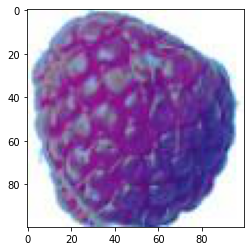

In [8]:
import matplotlib.pyplot as plt
img=Image.open('data/train/Raspberry/0_100.jpg')
plt.imshow(img, cmap='gray')

## Credentials for writing to / reading from Amazon S3

To avoid leaking credentials in notebooks:

### Using Cloud9 / Sagemaker
- No need as we are already logged in with credentials, so operating system already has access to credentials

### Local options: 
- set up AWS cli and get secrets as environment variables; or
- create secret `.aws/credentials` file which is ignored by git (add to `.gitignore`); and 
- use configparser to read and set environment variables



### [Access AWS from Google colab](https://medium.com/@lily_su/accessing-s3-bucket-from-google-colab-16f7ee6c5b51):
- save settings in your Google Drive: create a file `"content/drive/My Drive/config/awscli.ini"` (or whatever):
  ```text
  [default]
  aws_access_key_id = <your access key id> 
  aws_secret_access_key = <your secret access key>
  region = <your region>
  ```
- in your notebook: 
    ```python
    from google.colab import drive
    drive.mount("/content/drive")
    path = "/content/drive/My Drive/config/awscli.ini"
    os.environ["AWS_SHARED_CREDENTIALS_FILE"] = path
    # print(os.environ["AWS_SHARED_CREDENTIALS_FILE"])
    ```
-  install awscli:
    ```python
    !pip install awscli
    ```
-  any awscli commands can now pick up aws credentials from environment variables

## Load Images

Lire les images comme une stream


In [9]:
data_train_path='./data/train/**/*.jpg'
df_train = spark.read.format('image').load(data_train_path, inferschema=True)
df_train.count() 

24

In [10]:
data_train_path='./data/train'
df_train = spark.read.format('image').option('recursiveFileLookup', True).load(data_train_path, inferschema=True)
df_train.count() 

24

In [11]:
df_train.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [12]:
df_train.select('image.origin','image.height', 'image.width', 'image.nChannels').show(2,False)

+------------------------------------------------+------+-----+---------+
|origin                                          |height|width|nChannels|
+------------------------------------------------+------+-----+---------+
|file:///content/data/train/Raspberry/60_100.jpg |100   |100  |3        |
|file:///content/data/train/Pineapple/120_100.jpg|100   |100  |3        |
+------------------------------------------------+------+-----+---------+
only showing top 2 rows



Extract label from directory of image

In [13]:
# from pyspark.sql.functions import element_at, split

df_image = (df_train.withColumn('label',F.element_at(F.split(df_train['image.origin'],"/"),-2)))
df_image.printSchema()


root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- label: string (nullable = true)



In [14]:
df_image.select("image.origin", "image.width", "image.height",
                 "image.nChannels", "image.mode","label").show(5,False)

+------------------------------------------------+-----+------+---------+----+---------+
|origin                                          |width|height|nChannels|mode|label    |
+------------------------------------------------+-----+------+---------+----+---------+
|file:///content/data/train/Raspberry/60_100.jpg |100  |100   |3        |16  |Raspberry|
|file:///content/data/train/Pineapple/120_100.jpg|100  |100   |3        |16  |Pineapple|
|file:///content/data/train/Raspberry/180_100.jpg|100  |100   |3        |16  |Raspberry|
|file:///content/data/train/Pineapple/240_100.jpg|100  |100   |3        |16  |Pineapple|
|file:///content/data/train/Raspberry/300_100.jpg|100  |100   |3        |16  |Raspberry|
+------------------------------------------------+-----+------+---------+----+---------+
only showing top 5 rows



In [15]:
df_image.groupBy('label').count().show()

+---------+-----+
|    label|count|
+---------+-----+
|Pineapple|    5|
|   Orange|    5|
|Raspberry|    5|
|     Kiwi|    4|
|Blueberry|    5|
+---------+-----+



# Transfer learning

https://docs.databricks.com/applications/machine-learning/preprocess-data/transfer-learning-tensorflow.html 

Distributed featurization using pandas UDFs
- Load data using Apache Spark's binary files data source
- Load and prepare a model for featurization
- Compute features using a Scalar Iterator pandas UDF


In [16]:
df_images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", True) \
  .load("./data/train")

df_images.printSchema()


root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [17]:
df_images.limit(5).select('path').head(5)


[Row(path='file:/content/data/train/Raspberry/60_100.jpg'),
 Row(path='file:/content/data/train/Pineapple/120_100.jpg'),
 Row(path='file:/content/data/train/Raspberry/180_100.jpg'),
 Row(path='file:/content/data/train/Pineapple/240_100.jpg'),
 Row(path='file:/content/data/train/Raspberry/300_100.jpg')]

### Add label to images

In [18]:
df_images = (df_images.withColumn('label',F.element_at(F.split(df_images['path'],"/"),-2)))
df_images.limit(5).select('path','label').head(5)

[Row(path='file:/content/data/train/Raspberry/60_100.jpg', label='Raspberry'),
 Row(path='file:/content/data/train/Pineapple/120_100.jpg', label='Pineapple'),
 Row(path='file:/content/data/train/Raspberry/180_100.jpg', label='Raspberry'),
 Row(path='file:/content/data/train/Pineapple/240_100.jpg', label='Pineapple'),
 Row(path='file:/content/data/train/Raspberry/300_100.jpg', label='Raspberry')]

### Prepare your model
Download a model file for featurization, and truncate the last layer(s). This notebook uses ResNet50.

Spark workers need to access the model and its weights.

- For moderately sized models (< 1GB in size), a good practice is to download the model to the Spark driver and then broadcast the weights to the workers.
- This notebook uses this approach.
For large models (> 1GB), it is best to load the model weights from distributed storage to workers directly.

In [19]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

In [20]:

model = ResNet50(include_top=False)
# model.summary()  # verify that the top layer is removed

In [21]:
bc_model_weights = spark.sparkContext.broadcast(model.get_weights())

def model_fn():
  """
  Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
  """
  model = ResNet50(weights=None, include_top=False)
  model.set_weights(bc_model_weights.value)
  return model

### Define image loading and featurization logic in a Pandas UDF
This notebook defines the logic in steps, building up to the Pandas UDF. The call stack is:

- pandas UDF
  - featurize a pd.Series of images
    - preprocess one image

This notebook uses the newer Scalar Iterator pandas UDF to amortize the cost of loading large models on workers.



In [22]:
import numpy as np
import pandas as pd


def preprocess(content):
  """
  Preprocesses raw image bytes for prediction.
  """
  img = Image.open(io.BytesIO(content)).resize([224, 224])
  arr = img_to_array(img)
  return preprocess_input(arr)

def featurize_series(model, content_series):
  """
  Featurize a pd.Series of raw images using the input model.
  :return: a pd.Series of image features
  """
  input = np.stack(content_series.map(preprocess))
  preds = model.predict(input)
  # For some layers, output features will be multi-dimensional tensors.
  # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
  output = [p.flatten() for p in preds]
  return pd.Series(output)


In [23]:
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from typing import Iterator


@pandas_udf('array<float>')
def featurize_udf(content_series_iter: Iterator[pd.Series])->Iterator[pd.Series]:
  '''
  This method is a Scalar Iterator pandas UDF wrapping our featurization function.
  The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
  :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
  '''
  # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
  # for multiple data batches.  This amortizes the overhead of loading big models.
  model = model_fn()
  for content_series in content_series_iter:
    yield featurize_series(model, content_series)

## Apply featurization to the DataFrame of images


In [24]:
# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", 1024)


In [25]:
# We can now run featurization on our entire Spark DataFrame.
# NOTE: This can take a long time (about 10 minutes) since it applies a large model to the full dataset.
df_features = df_images.repartition(16).select(col("path"), featurize_udf("content").alias("features"))
df_features.write.mode("overwrite").parquet("tmp/fruit_image_features")

## Features 

In [26]:
df_features.printSchema()

root
 |-- path: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [27]:
def spark_shape(df):
    return (df.count(), len(df.columns))

spark_shape(df_features)

(24, 2)

## Train a new model using pre-computed features

The final step in transfer learning would be to use our pre-computed features to train a new model for a new task, such as classifying flowers. We omit that step in this notebook. 